This process will take all the 2018-2019 periods as features and will use those to predict reviews for each 2020 period. Differences in the overall accuracy of each model as well as shifts in the importance of different features to the model may indicate COVID-related change.

In [1]:
import datetime
import numpy as np
import pandas as pd

import aggregator as ag
import monthly_modeler as mm

In [2]:
#data_file_name_review = "distributed_data_collection/databases/review_data_sample.csv"
#data_file_name_book = "distributed_data_collection/databases/book_data_sample.csv"

data_file_name_review = "distributed_data_collection/databases/review_data.csv"
data_file_name_book = "distributed_data_collection/databases/book_data.csv"
data_file_name_subject = "subject_matching/data/sub_feat_all.csv"

start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2020, 9, 30)

#book_columns = ["num_reviews", "num_ratings", "avg_rating"] #BASELINE
book_columns = ["num_reviews", "num_ratings", "avg_rating", "book_language", "series", "book_author"]

Theoretically, we could test against multiple grains (ie, day, week, month, quarter). However, I am only working with month. I ruled out the quarterly grain because it wouldn't include enough 2020 time periods to observe a trend in model performance over time. Then because the maximum monthly review counts were in the seventies, I didn't feel I could split those further.

I want to drop binary feature columns which have a small number of values. The linear regression regularization will do a rigorous feature selection, so this step is mostly to reduce the amount of data that it has to process.

In [3]:
data_aggregator = ag.Aggregator(data_file_name_review, data_file_name_book, book_columns, start_date, end_date, "month")
data_aggregator.aggregate("by_book")
data_aggregator.sparsity_filter(2)

time_periods_post = data_aggregator.get_annual_time_periods(2020)
data_train, data_test = data_aggregator.get_train_test_split(0.75)

Aggregator Initiated.
Processing Scraper Output...
Scraper Output Processed.
Aggregating Review Data...
Review Data Aggregated.
Merging Book Data...
Book Data Merged.
Applying Sparsity Filter...
Dropped 10,112/12,295 columns. 2,183 columns remaining.


We want to iterate through: logorithmic transformation, regularization type, and alpha value. For the moment, I am turning logorithmic transformation off. It's pretty clear that it has no impact, and I don't want to keep running it while I experiment with other aspects of the modeling process.

In [4]:
#alpha_list = [1] #BASELINE
alpha_list = [np.log2(x) for x in range(2,11)] + [5, 10]

#regression_types_list = ["linear"] #BASELINE
regression_types_list = ["linear", "ridge", "lasso"]

#is_log_options = [False, True]
is_log_options = [False] 

Here goes on modeling! We will select the best model for each time period based on MSE. The performance df captures the overall predictiveness of pre-period data on post-period data. We expect to see declines due to concept drift. Sharp dropoffs in performance might suggest larger changes in reading trends.

In [5]:
regression_processor = mm.Regression_Processor(data_train, data_test, time_periods_post, regression_types_list, is_log_options, alpha_list)
performance_df, model_dict = regression_processor.get_optimal_models()

print(performance_df.round(3))

10/207 models processed
20/207 models processed
30/207 models processed
40/207 models processed
50/207 models processed
60/207 models processed
70/207 models processed
80/207 models processed
90/207 models processed
100/207 models processed
110/207 models processed
120/207 models processed
130/207 models processed
140/207 models processed
150/207 models processed
160/207 models processed
170/207 models processed
180/207 models processed
190/207 models processed
200/207 models processed
207/207 models processed
  post_period regression_type is_log  alpha  mse_test  r2_train  r2_test
0     2020-01           ridge  False    1.0     7.276     0.865    0.480
1     2020-02           ridge  False    1.0     4.104     0.822    0.315
2     2020-03           ridge  False    1.0     4.778     0.804    0.324
3     2020-04           ridge  False    1.0     7.432     0.862    0.308
4     2020-05           ridge  False    1.0    11.126     0.838    0.272
5     2020-06           ridge  False    1.0   

This is where it's really at! Understanding what features are most important to each model can help us understand the drivers of reading in each period.

In [6]:
coefficient_df = regression_processor.get_coefficient_df()
coefficient_df = regression_processor.print_top_coefficients()

                                                    review_count 2020-01
feature_name                                                            
series_The Handmaid\'s Tale                                    -4.309252
book_author_Liv Constantine                                    -2.944878
series_Will this be a series or is it a stand a...             -2.924920
book_author_Yann Martel                                         2.722663
book_author_Dale Carnegie                                       2.624173
book_author_Fredrik Backman  Neil Smith (Transl...             -2.539413
book_author_A.J. Finn                                          -2.474775
book_author_Chloe  Benjamin                                    -2.405416
book_author_Audrey Niffenegger                                  2.388920
book_author_Beth O'Leary                                        2.160488
                                                    review_count 2020-02
feature_name                                       

I also want to understand the relative importance of each historical period. Even if it isn't the main driver, it should give some indication of whether trends are changing.

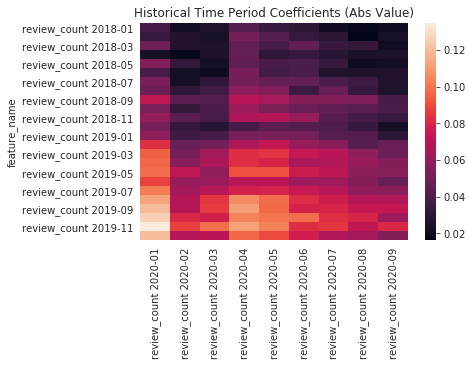

In [7]:
pre_period_importance = regression_processor.get_pre_period_importance()